<a href="https://colab.research.google.com/github/zahrafali/PatternRecognition/blob/main/PR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Helper Functions
# Normalizing the points in th range 0 to 1 (low=0, high=1)
import numpy as np


def normalize_data(class1, class2, low, high):
    class1 = np.array(class1)
    class2 = np.array(class2)
    total_points = np.append(class1, class2, axis=1)
    mins = np.array([np.min(total_points, axis=1)]).transpose()
    maxs = np.array([np.max(total_points, axis=1)]).transpose()
    rng = maxs - mins
    class1_normalized = high - (((high - low) * (maxs - class1)) / rng)
    class2_normalized = high - (((high - low) * (maxs - class2)) / rng)
    return class1_normalized, class2_normalized

#@title Plotting
########################################################################################
# PLOTTING #
import matplotlib.pyplot as plt
import numpy as np
import math
from prettytable import PrettyTable

def plot_2d_graph(w1_matrix, w2_matrix, x1, x2, x1_label, x2_label, title):
    plt.plot(w1_matrix[x1 - 1], w1_matrix[x2 - 1], 'r.', label="Class 1")
    plt.plot(w2_matrix[x1 - 1], w2_matrix[x2 - 1], 'b.', label="Class 2")
    plt.xlabel(x1_label)
    plt.ylabel(x2_label)
    max_w = max(max(max(w1_matrix[x1-1]), max(w2_matrix[x2-1])),
                max(max(w1_matrix[x1-1]), max(w2_matrix[x2-1])))
    min_w = min(min(min(w1_matrix[x1-1]), min(w2_matrix[x2-1])),
                min(min(w1_matrix[x1-1]), min(w2_matrix[x2-1])))
    plt.axis([min_w, max_w, min_w, max_w])
    plt.title(title)
    plt.legend(loc=1)

#@title MAXIMUM LIKELIHOOD MEAN & COVARIANCE
########################################################################################
# Mean Estimate Maximum Likelihood
import numpy as np


def mleMean(points_matrix, N):
    points = np.array(points_matrix)
    points = points[:, :N]
    mean = np.sum(points, axis=1)
    mean = mean / N
    mean = np.array(mean)[np.newaxis]
    return mean.transpose()

# Covariance Estimate Maximum Likelihood
def mleCov(points_matrix, M, N):
  points = np.array(points_matrix)
  M = np.array(M)
  covariance = ((points_matrix - M) @ (points_matrix - M).transpose()) / N
  return covariance

########################################################################################
# Mean Estimate Bayesian
def bayesianMean(points, mean0, cov_initial, cov_actual, n):
    points_sum = np.sum(points, axis=1) / n
    points_sum = np.array(points_sum)[np.newaxis]
    points_sum = points_sum.transpose()
    for i in range(10,n+10,10):
        var1 = (1/n) * cov_actual # 1/N * sigma
        var2 = var1 + cov_initial # 1/N * sigma + cov_initial
        inv_var2 = np.linalg.inv(var2)
        firstPart_m_n = np.dot(np.dot(var1,inv_var2),mean0)
        
        secondpart_m_n = np.dot(np.dot(cov_initial,inv_var2),points_sum)
        m_n = firstPart_m_n +secondpart_m_n

    return m_n
########################################################################
#@title PARZEN HELPER FUNCTIONS AND VARIABLES
def kernel_function(x, xi, cov):
    result = (1 / (math.sqrt(2 * math.pi) * cov)) * math.exp(-math.pow(x - xi, 2) / (2 * math.pow(cov, 2)))
    return result


def parzen_expected_mean(x, f_x, delta_x):
    return x * f_x * delta_x


def parzen_expected_covariance(x, f_x, delta_x, mean):
    return math.pow(x - mean, 2) * f_x * delta_x

kernel_covariance = 0.3
kernel_points = 100

step_size = 0.01


#@title PARZEN ESTIMATION FUNCTION
def parzenEstimations(x1_training_points, x2_training_points, show_plot, dim):
  x1_parzen_estimated_mean = []
  x1_parzen_estimated_covariance = []

  x2_parzen_estimated_mean = []
  x2_parzen_estimated_covariance = []

  for i in range(0, dim, 1):
      # for class 1
      f_x1_points = []
      f_x1_values = []
      for j in np.arange(min(x1_training_points[i, :]) - 1, max(x1_training_points[i, :]), step_size):
          f_x1_points = np.append(f_x1_points, j)

      f_x1_points = np.sort(f_x1_points)

      for x in f_x1_points:
          f_x = 0.0
          for xi in x1_training_points[i, :]:
              f_x = f_x + kernel_function(x, xi, kernel_covariance)
          f_x = f_x / x1_training_points[i, :].size
          f_x1_values = np.append(f_x1_values, f_x)

      estimated_mean = 0.0
      for x in range(0, f_x1_points.size):
          estimated_mean = estimated_mean + parzen_expected_mean(f_x1_points[x], f_x1_values[x], step_size)
      x1_parzen_estimated_mean = np.append(x1_parzen_estimated_mean, estimated_mean)

      estimated_covariance = 0.0
      for x in range(0, f_x1_points.size):
          estimated_covariance = estimated_covariance + parzen_expected_covariance(f_x1_points[x], f_x1_values[x],
                                                                                    step_size, estimated_mean)
      x1_parzen_estimated_covariance = np.append(x1_parzen_estimated_covariance, estimated_covariance)

      # for class 2
      f_x2_points = []
      f_x2_values = []
      for j in np.arange(min(x2_training_points[i, :]) - 1, max(x2_training_points[i, :]), step_size):
          f_x2_points = np.append(f_x2_points, j)
      f_x2_points = np.sort(f_x2_points)

      for x in f_x2_points:
          f_x = 0.0
          for xi in x2_training_points[i, :]:
              f_x = f_x + kernel_function(x, xi, kernel_covariance)
          f_x = f_x / x2_training_points[i, :].size
          f_x2_values = np.append(f_x2_values, f_x)

      estimated_mean = 0.0
      for x in range(0, f_x2_points.size):
          estimated_mean = estimated_mean + parzen_expected_mean(f_x2_points[x], f_x2_values[x], step_size)
      x2_parzen_estimated_mean = np.append(x2_parzen_estimated_mean, estimated_mean)

      estimated_covariance = 0.0
      for x in range(0, f_x2_points.size):
          estimated_covariance = estimated_covariance + parzen_expected_covariance(f_x2_points[x], f_x2_values[x],
                                                                                    step_size, estimated_mean)
      x2_parzen_estimated_covariance = np.append(x2_parzen_estimated_covariance, estimated_covariance)

      min_x_axis = min(min(x1_training_points[i, :]), min(x2_training_points[i, :]))
      max_x_axis = max(max(x1_training_points[i, :]), max(x2_training_points[i, :]))

      title = 'f(v' + str(i + 1) + ')'

      # parzen window plots
      if show_plot == True:
        plt.plot(f_x1_points, f_x1_values, 'r--', label="class 1")
        plt.plot(f_x2_points, f_x2_values, 'b--', label="class 2")

        plt.xlabel('v values')
        plt.ylabel('f(v)')

        plt.xlim(min_x_axis, max_x_axis)
        plt.title(title)
        plt.legend(loc=2)
        plt.show()
  x1_parzen_estimated_mean = np.array(x1_parzen_estimated_mean)[np.newaxis]
  x1_parzen_estimated_mean = x1_parzen_estimated_mean.transpose()

  x2_parzen_estimated_mean = np.array(x2_parzen_estimated_mean)[np.newaxis]
  x2_parzen_estimated_mean = x2_parzen_estimated_mean.transpose()

  x1_parzen_estimated_covariance = np.diag(x1_parzen_estimated_covariance)
  x2_parzen_estimated_covariance = np.diag(x2_parzen_estimated_covariance)
  return x1_parzen_estimated_mean, x2_parzen_estimated_mean, x1_parzen_estimated_covariance, x2_parzen_estimated_covariance

###################################################################
# Simultaneous Diagonalization.
# This is a process of diagonalizing two classes
# using the data points, their means and covariance matrices

########################################################################################
import numpy as np

def simultaneousDiagonalization(x1_matrix, x2_matrix, sigma_x1, sigma_x2, m_x1, m_x2):
  w_x1, v_x1 = np.linalg.eig(sigma_x1)
  lambda_x1 = np.diag(w_x1)

  # w_x2 = eigenvalues, v_x2 = eigenvectors
  w_x2, v_x2 = np.linalg.eig(sigma_x2)
  lambda_x2 = np.diag(w_x2)

  # means for y1 and y2
  m_y1 = v_x1.transpose() @ m_x1
  m_y2 = v_x2.transpose() @ m_x2

  # means for z1 and z2
  m_z1 = v_x1.transpose() @ m_y1
  m_z2 = v_x2.transpose() @ m_y2

  m_v1 = v_x1.transpose() @ m_z1
  m_v2 = v_x2.transpose() @ m_z2
 
  # STEP 1

  # transform points for two classes in Y world
  y1_matrix = v_x1.transpose() @ x1_matrix
  y2_matrix = v_x1.transpose() @ x2_matrix

  # covariances of y1 and y2 (classes 1 and 2 in Y world)
  sigma_y1 = v_x1.transpose() @ sigma_x1 @ v_x1
  sigma_y2 = v_x1.transpose() @ sigma_x2 @ v_x1

  w_y1, v_y1 = np.linalg.eig(sigma_y1)
  w_y2, v_y2 = np.linalg.eig(sigma_y2)
  # transform points for the two classes in Z

  # z1_matrix = np.diag(np.power(w_x1, -0.5)) @ v_x1.transpose() @ x1_matrix
  # z2_matrix = np.diag(np.power(w_x1, -0.5)) @ v_x1.transpose() @ x2_matrix
  z1_matrix = np.diag(np.power(w_x1, -1/2)) @ y1_matrix
  z2_matrix = np.diag(np.power(w_x2, -1/2)) @ y2_matrix
  # covariance matrix of z1 and z2

  # sigma_z1 = np.diag(np.power(w_x1, -1/2)) @ sigma_y1 @ np.diag(np.power(w_x1, -1/2))
  # sigma_z2 = np.diag(np.power(w_x1, -1/2)) @ sigma_y2 @ np.diag(np.power(w_x1, -1/2))
  sigma_z1 = np.diag(np.power(w_x1, -0.5)) @ np.diag(w_x1) @ np.diag(np.power(w_x1, -0.5))
  sigma_z2 = np.diag(np.power(w_x1, -0.5)) @ v_x1.transpose() @ sigma_x2 @ v_x1 @ np.diag(np.power(w_x1, -0.5))

  # eigenvalues and eigenvectors of z2 covariance
  w_z1, v_z1 = np.linalg.eig(sigma_z1)
  w_z2, v_z2 = np.linalg.eig(sigma_z2)
 
  # P - Overall multiplying matrix used to multiply each point for the final transformation
  P_o = v_z2.transpose() @ np.diag(np.power(w_x1, -0.5)) @ v_x1.transpose()

  # simultaneous diagonalization means
  m_v1 = P_o @ m_x1
  m_v2 = P_o @ m_x2
  # simultaneous diagonalization matrices
  v1_matrix = P_o @ x1_matrix
  v2_matrix = P_o @ x2_matrix

  # covariance matrix of v1 and v2
  sigma_v1 = np.round(v_z2.transpose() @ sigma_z1 @ v_z2, 2)
  sigma_v2 = np.round(v_z2.transpose() @ sigma_z2 @ v_z2, 2)
  
  return v1_matrix, v2_matrix, sigma_v1, sigma_v2, m_v1, m_v2

#@title BAYES DISCRIMINANT FUNCTIONS CALCULATION AND PLOTTING
import numpy as np
import matplotlib.pyplot as plt

def bayesDiscriminant(m1, m2, cov1, cov2, x1_points, x2_points, p1, p2, d1, d2, method):
  a = ((np.linalg.inv(cov2) - np.linalg.inv(cov1)) / 2)
  b = np.array(m1.transpose() @ np.linalg.inv(cov1) - m2.transpose() @ np.linalg.inv(cov2))
  c = (np.math.log(p1 / p2) + np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))
  # c= (np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))/2 + np.math.log(p1 / p2) + ( ( m2.transpose() @ np.linalg.inv(cov2) @ m1)-(m1.transpose() @ np.linalg.inv(cov1) @ m1))
  equation_points = []
  roots_1 = []
  roots_2 = []

  min_w = min(min(min(x1_points[d1 - 1]), min(x2_points[d1 - 1])),
              min(min(x1_points[d2 - 1]), min(x2_points[d2 - 1])))
  max_w = max(max(max(x1_points[d1 - 1]), max(x2_points[d1 - 1])),
              max(max(x1_points[d2 - 1]), max(x2_points[d2 - 1])))

  for x1 in np.arange(min_w - 1, max_w + 1, 1):
      equation_points.append(x1)
      x2_square_coefficient = a[d2 - 1][d2 - 1]
      x2_coefficient = (a[d1 - 1][d2 - 1] * x1) + (a[d2 - 1][d1 - 1] * x1) + b[0][d2 - 1]
      constant = a[d1 - 1][d1 - 1] * np.math.pow(x1, 2) + b[0][d1 - 1] * x1 + c

      poly_coefficients = [x2_square_coefficient, x2_coefficient, constant]
      roots = np.roots(poly_coefficients)
      roots_1.append(roots[0])
      roots_2.append(roots[1])

  # plot_2d_graph_with_line(x1_points, x2_points, d1, d2, str(d1), str(d2), method, equation_points_x2x3, roots_1_x2x3, roots_2_x2x3)
  plt.plot(x1_points[d1 - 1], x1_points[d2 - 1], 'r.', label="Class 1")
  plt.plot(x2_points[d1 - 1], x2_points[d2 - 1], 'b.', label="Class 2")
  plt.plot(equation_points, roots_2, 'g--', label="Dis.Fnc.")
  plt.plot(equation_points, roots_1, 'y--', label="Dis.Fnc.")
  plt.xlabel('x' + str(d1))
  plt.ylabel('x' + str(d2))

  plt.axis([min_w, max_w, min_w, max_w])
  plt.title('Dis. Fun. for ' + method + ' for x' + str(d1) + '-x' + str(d2))
  plt.legend(loc=2)
  plt.show()

########################################################################################
# calculate the discriminant value for a given point or set of points
def calculateDiscriminant(X_val, sigma_1, sigma_2, mean_1, mean_2, p1, p2): 
    X = []
    sigma_1 = np.array(sigma_1)
    sigma_2 = np.array(sigma_2)
    mean_1 = np.array(mean_1)
    mean_2 = np.array(mean_2)

    A = ((np.linalg.inv(sigma_2) - np.linalg.inv(sigma_1)) / 2)
    B = np.array(mean_1.transpose() @ np.linalg.inv(sigma_1) - mean_2.transpose() @ np.linalg.inv(sigma_2),
                 dtype=np.float64)
    C =  np.math.log(p1 / p2) + np.log(np.linalg.det(sigma_2) / np.linalg.det(sigma_1)) 
    # C =  np.math.log(p1 / p2) + np.log(np.linalg.det(sigma_2) / np.linalg.det(sigma_1))  + ( ( mean_2.transpose() @ np.linalg.inv(sigma_2) @ mean_2)-(mean_1.transpose() @ np.linalg.inv(sigma_1) @ mean_1))

    
    discriminant_value = []
    if len(X_val) > 0:
        X = np.array(X_val)
        discriminant_value = X.transpose() @ A @ X + B @ X + C

    return A, B, C, discriminant_value
########################################################################################
########################################################################################
#################################################################
#@title Test Classifier helper function

def test_classifier(class1_test_points, class2_test_points, x1_estimated_cov, x2_estimated_cov,
                    x1_estimated_mean, x2_estimated_mean, class1_testing_points_count,
                    class2_testing_points_count, p1, p2):
    # classification results
    class1_true = 0.0
    class1_false = 0.0

    class2_true = 0.0
    class2_false = 0.0
    
    # classify each point
    for j in range(class1_testing_points_count):
        _, _, _, discriminant_value = calculateDiscriminant(class1_test_points[:, j], x1_estimated_cov,
                                                      x2_estimated_cov, x1_estimated_mean, x2_estimated_mean,
                                                      p1,
                                                      p2)
        # print("class1 Disc Val: ", discriminant_value)
        if discriminant_value > 0:
            class1_true += 1
        else:
            class1_false += 1

    for j in range(class2_testing_points_count):
        _, _, _, discriminant_value = calculateDiscriminant(class2_test_points[:, j], x1_estimated_cov,
                                                      x2_estimated_cov, x1_estimated_mean, x2_estimated_mean,
                                                      p1,
                                                      p2)
        # print("class2 Disc Val: ", discriminant_value)
        if discriminant_value < 0:
            class2_true += 1
        else:
            class2_false += 1

    class1_accuracy = (class1_true / len(class1_test_points[0])) * 100
    class2_accuracy = (class2_true / len(class2_test_points[0])) * 100

    total_accuracy = (class1_true + class2_true) * 100 / (len(class1_test_points[0]) + len(class2_test_points[0]))

    # print(class1_true, class1_false)
    # print(class2_true, class2_false)
    # print(total_accuracy)
    return class1_accuracy, class2_accuracy, total_accuracy

    #################################################################





This is a pattern recognition system that uses heart disease dataset found [here](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset). This dataset consists of 14 features(attributes). 

The last column "target" refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

In [2]:
#@title Dataset
import pandas as pd
import numpy as np
from sklearn import preprocessing

df1 = pd.read_csv('heart.csv')
df1

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


This project only requires 6 features, we will select the 6 most significant features which the target column is most correlated.


In [3]:
df1.corr().style.background_gradient() 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.103240,-0.071966,0.271121,0.219823,0.121243,-0.132696,-0.390227,0.088163,0.208137,-0.169105,0.271551,0.072297,-0.229324
sex,-0.103240,1.000000,-0.041119,-0.078974,-0.198258,0.027200,-0.055117,-0.049365,0.139157,0.084687,-0.026666,0.111729,0.198424,-0.279501
cp,-0.071966,-0.041119,1.000000,0.038177,-0.081641,0.079294,0.043581,0.306839,-0.401513,-0.174733,0.131633,-0.176206,-0.163341,0.434854
trestbps,0.271121,-0.078974,0.038177,1.000000,0.127977,0.181767,-0.123794,-0.039264,0.061197,0.187434,-0.120445,0.104554,0.059276,-0.138772
chol,0.219823,-0.198258,-0.081641,0.127977,1.000000,0.026917,-0.147410,-0.021772,0.067382,0.064880,-0.014248,0.074259,0.100244,-0.099966
fbs,0.121243,0.027200,0.079294,0.181767,0.026917,1.000000,-0.104051,-0.008866,0.049261,0.010859,-0.061902,0.137156,-0.042177,-0.041164
restecg,-0.132696,-0.055117,0.043581,-0.123794,-0.147410,-0.104051,1.000000,0.048411,-0.065606,-0.050114,0.086086,-0.078072,-0.020504,0.134468
thalach,-0.390227,-0.049365,0.306839,-0.039264,-0.021772,-0.008866,0.048411,1.000000,-0.380281,-0.349796,0.395308,-0.207888,-0.098068,0.422895
exang,0.088163,0.139157,-0.401513,0.061197,0.067382,0.049261,-0.065606,-0.380281,1.000000,0.310844,-0.267335,0.107849,0.197201,-0.438029
oldpeak,0.208137,0.084687,-0.174733,0.187434,0.064880,0.010859,-0.050114,-0.349796,0.310844,1.000000,-0.575189,0.221816,0.202672,-0.438441


From the correlation marix we can see that the 6 most corelated features in decresing order of correlation are - 


1.   cp (chest pain)
2.   thalach (maximum heart rate achieved)
3.   slope (the slope of the peak exercise ST segment)
4.   restecg (resting electrocardiographic results)
5.   fbs (fastnig blood sugar)
6.   chol (cholestrol)



1    526
0    499
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


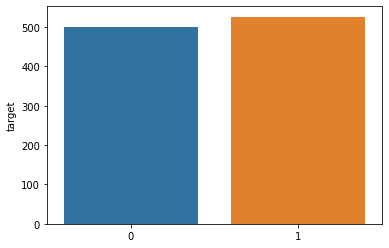

In [4]:
#@title Visualising the data class distribution


import seaborn as sns
import matplotlib.pyplot as plt
y=df1['target'].value_counts()
print(y)
x = y.index
sns.barplot(x,y)

There are a total of 1029 entries out of which 499 belong to class1 (target=0) and 526 belong to class2 (target=1). 

# Data Preprocssing
*   We will now split the data equally to use as train and test.
*   After splitting the data we will include only the 6 features based on the correlation matrix.
*   We chose to divide thalach and chol by 100 to normalize the values to single digit(with decimal)
*   We then normalized all the points between the range 0-1.







In [5]:
#@title Preprocessing both training and testing data
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df1, test_size=0.5, random_state=25)

#########################################################
#training data
x1 = training_data[training_data['target'] == 0]
cp_1 = x1['cp']
thalach_1 = x1['thalach']/100
slope_1 = x1['slope']
restecg_1 = x1['restecg']
fbs_1 = x1['fbs']
chol_1 = x1['chol']/100
x1_matrix_raw = [list(cp_1), list(thalach_1), list(slope_1), list(restecg_1), list(fbs_1), list(chol_1)]

x2 = training_data[training_data['target'] > 0]
cp_2 = x2['cp']
thalach_2 = x2['thalach']/100
slope_2 = x2['slope']
restecg_2 = x2['restecg']
fbs_2 = x2['fbs']
chol_2 = x2['chol']/100
x2_matrix_raw = [list(cp_2), list(thalach_2), list(slope_2), list(restecg_2), list(fbs_2), list(chol_2)]

########################################################
#test data
x1_t = testing_data[testing_data['target'] == 0]
cp_1_t = x1_t['cp']
thalach_1_t = x1_t['thalach']/100
slope_1_t = x1_t['slope']
restecg_1_t = x1_t['restecg']
fbs_1_t = x1_t['fbs']
chol_1_t = x1_t['chol']/100
x1_matrix_raw_t = [list(cp_1_t), list(thalach_1_t), list(slope_1_t), list(restecg_1_t), list(fbs_1_t), list(chol_1_t)]

x2_t = testing_data[testing_data['target'] > 0]
cp_2_t = x2_t['cp']
thalach_2_t = x2_t['thalach']/100
slope_2_t = x2_t['slope']
restecg_2_t = x2_t['restecg']
fbs_2_t = x2_t['fbs']
chol_2_t = x2_t['chol']/100
x2_matrix_raw_t = [list(cp_2_t), list(thalach_2_t), list(slope_2_t), list(restecg_2_t), list(fbs_2_t), list(chol_2_t)]

# Normalizing range 0 to 1
x1_matrix, x2_matrix = normalize_data(x1_matrix_raw, x2_matrix_raw, 0, 1)
# probability of class1
p1 = (len(x1_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) )
# probability of class2
p2 = (len(x2_matrix[0])/ (len(x1_matrix[0]) + len(x2_matrix[0])) )

x1_matrix_t, x2_matrix_t = normalize_data(x1_matrix_raw_t, x2_matrix_raw_t, 0, 1)
# probability of test class1
p1_test = (len(x1_matrix_t[0])/ (len(x1_matrix_t[0]) + len(x2_matrix_t[0])) )
# probability of test class2
p2_test = (len(x2_matrix_t[0])/ (len(x1_matrix_t[0]) + len(x2_matrix_t[0])) ) 

# Simulatneous Diagonalization of the points

In [6]:
#@title Calculating the Mean and Covariance using Maximum Likelihood Estimations
x1_no_of_points = len(x1_matrix[0])
# get estimated mean and covariance using ML method
x1_ml_estimated_mean = mleMean(x1_matrix, x1_no_of_points)
# x1_ml_estimated_cov = estimate_cov_ml(x1_training_points, x1_ml_estimated_mean, no_of_points)
print('\nEstimated Mean1 using ML before Diagonalization:')
print(x1_ml_estimated_mean)
x1_ml_estimated_cov = mleCov(x1_matrix, x1_ml_estimated_mean, x1_no_of_points)
print('\nEstimated covariance1 using ML before Diagonalization:')
print(x1_ml_estimated_cov)
x2_no_of_points = len(x2_matrix[0])
x2_ml_estimated_mean = mleMean(x2_matrix, x2_no_of_points)
x2_ml_estimated_cov = mleCov(x2_matrix, x2_ml_estimated_mean, x2_no_of_points)
print('\nEstimated Mean2 using ML before Diagonalization:')
print(x2_ml_estimated_mean)
print('\nEstimated covariance2 using ML before Diagonalization:')
print(x2_ml_estimated_cov)


Estimated Mean1 using ML before Diagonalization:
[[0.16256831]
 [0.52330747]
 [0.56557377]
 [0.23565574]
 [0.14754098]
 [0.28417172]]

Estimated covariance1 using ML before Diagonalization:
[[ 9.60669921e-02  1.18274709e-02  6.41628594e-03  6.24272149e-04
  -2.12756427e-03  5.03411057e-04]
 [ 1.18274709e-02  3.14591290e-02  2.14349750e-02 -2.24670018e-03
  -1.22576423e-04  8.97765568e-04]
 [ 6.41628594e-03  2.14349750e-02  7.97164741e-02 -8.39828003e-05
  -1.99207202e-02 -1.02903857e-03]
 [ 6.24272149e-04 -2.24670018e-03 -8.39828003e-05  7.45893241e-02
  -6.08035474e-03 -5.27607562e-03]
 [-2.12756427e-03 -1.22576423e-04 -1.99207202e-02 -6.08035474e-03
   1.25772642e-01  1.30230863e-03]
 [ 5.03411057e-04  8.97765568e-04 -1.02903857e-03 -5.27607562e-03
   1.30230863e-03  1.24677961e-02]]

Estimated Mean2 using ML before Diagonalization:
[[0.46144279]
 [0.6629828 ]
 [0.78358209]
 [0.30597015]
 [0.14179104]
 [0.25794827]]

Estimated covariance2 using ML before Diagonalization:
[[ 1.000887

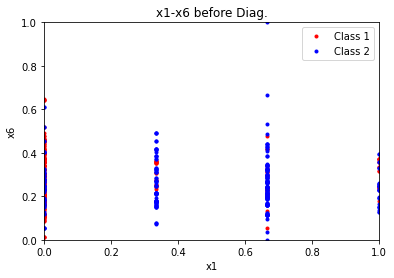

In [7]:
plot_2d_graph(x1_matrix, x2_matrix, 1, 6, 'x1', 'x6', 'x1-x6 before Diag.') #2,4


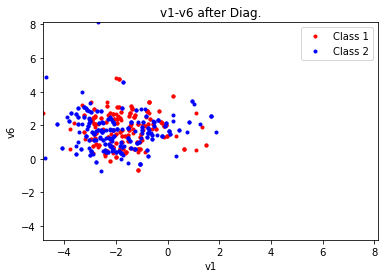

In [8]:
v1_matrix, v2_matrix, sigma_v1, sigma_v2, m_v1, m_v2 = simultaneousDiagonalization(x1_matrix, x2_matrix, x1_ml_estimated_cov, x2_ml_estimated_cov, x1_ml_estimated_mean, x2_ml_estimated_mean)
plot_2d_graph(v1_matrix, v2_matrix, 1, 6, 'v1', 'v6', 'v1-v6 after Diag.')

v1_matrix_t, v2_matrix_t, sigma_v1_t, sigma_v2_t, m_v1_t, m_v2_t = simultaneousDiagonalization(x1_matrix_t, x2_matrix_t, x1_ml_estimated_cov, x2_ml_estimated_cov, x1_ml_estimated_mean, x2_ml_estimated_mean)


# Classification
We implement a Quadratic classifier (Bayes Classifier) and A K-Nearest Neighbour classifier.


In [9]:
#@title Calculating the Mean and Covariance using Maximum Likelihood Estimations after Diagonalization
x1_no_of_points = len(x1_matrix[0])
# get estimated mean and covariance using ML method
v1_ml_estimated_mean = mleMean(v1_matrix, x1_no_of_points)
# x1_ml_estimated_cov = estimate_cov_ml(x1_training_points, x1_ml_estimated_mean, no_of_points)
print('\nEstimated Mean1 using ML after Diagonalization:')
print(v1_ml_estimated_mean)
v1_ml_estimated_cov = mleCov(v1_matrix, v1_ml_estimated_mean, x1_no_of_points)
print('\nEstimated covariance1 using ML after Diagonalization:')
print(v1_ml_estimated_cov)
x2_no_of_points = len(x2_matrix[0])
v2_ml_estimated_mean = mleMean(v2_matrix, x2_no_of_points)
v2_ml_estimated_cov = mleCov(v2_matrix, v2_ml_estimated_mean, x2_no_of_points)
print('\nEstimated Mean2 using ML after Diagonalization:')
print(v2_ml_estimated_mean)
print('\nEstimated covariance2 using ML after Diagonalization:')
print(v2_ml_estimated_cov)


Estimated Mean1 using ML after Diagonalization:
[[-1.63228581]
 [ 1.05050271]
 [-2.10171494]
 [-0.06712237]
 [ 2.54860766]
 [ 1.79725257]]

Estimated covariance1 using ML after Diagonalization:
[[ 1.00000000e+00  6.60965836e-16 -5.90387993e-16 -1.32991707e-15
  -1.33170465e-15 -6.30787900e-16]
 [ 6.60965836e-16  1.00000000e+00 -1.08405558e-15  2.44613817e-16
  -1.58600348e-15 -7.82121943e-16]
 [-5.90387993e-16 -1.08405558e-15  1.00000000e+00  8.16836957e-16
   1.00261858e-15 -3.21368699e-16]
 [-1.32991707e-15  2.44613817e-16  8.16836957e-16  1.00000000e+00
   2.69201283e-15 -1.67530442e-16]
 [-1.33170465e-15 -1.58600348e-15  1.00261858e-15  2.69201283e-15
   1.00000000e+00 -7.46236687e-17]
 [-6.30787900e-16 -7.82121943e-16 -3.21368699e-16 -1.67530442e-16
  -7.46236687e-17  1.00000000e+00]]

Estimated Mean2 using ML after Diagonalization:
[[-1.89861356]
 [ 0.49735584]
 [-3.06813443]
 [-0.51321379]
 [ 2.89064767]
 [ 1.60755547]]

Estimated covariance2 using ML after Diagonalization:
[[ 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


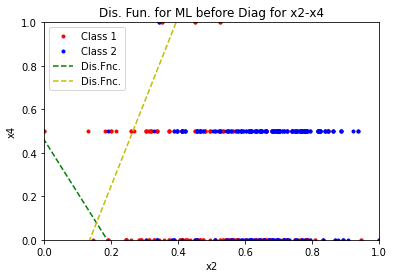

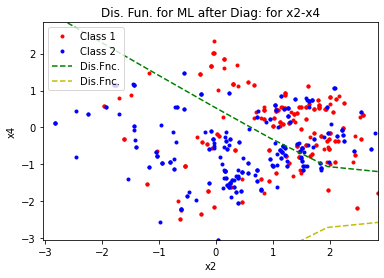

In [10]:
#@title Plotting Bayes dicriminant for MLE

bayesDiscriminant(x1_ml_estimated_mean, x2_ml_estimated_mean, x1_ml_estimated_cov,
                                    x2_ml_estimated_cov, x1_matrix, x2_matrix, p1, p2, 2, 4, 'ML before Diag')
bayesDiscriminant(v1_ml_estimated_mean, v2_ml_estimated_mean, v1_ml_estimated_cov,
                                    v2_ml_estimated_cov, v1_matrix, np.array(v2_matrix), p1, p2, 2, 4, 'ML after Diag:')


In [11]:
#@title Calculating the Mean and Covariance using Bayesian Learning Method
# estimated mean using Bayesian Learning method
x1_no_of_points = len(x1_matrix[0])
x2_no_of_points = len(x2_matrix[0])
sigma0 = np.identity(6)
m1_0 = np.array([[0],
                 [0],
                 [0],
                 [0],
                 [0],
                 [0]])

x1_bl_estimated_mean = bayesianMean(x1_matrix, m1_0, sigma0, x1_ml_estimated_cov, x1_no_of_points)
x2_bl_estimated_mean = bayesianMean(x2_matrix, m1_0, sigma0, x2_ml_estimated_cov, x2_no_of_points)
print('\nEstimated mean 1 using BL before Diagonalization:')
print(x1_bl_estimated_mean)
print('\nEstimated mean 2 using BL before Diagonalization:')
print(x2_bl_estimated_mean)


Estimated mean 1 using BL before Diagonalization:
[[0.16246421]
 [0.52318367]
 [0.56535216]
 [0.23559813]
 [0.14751713]
 [0.28416163]]

Estimated mean 2 using BL before Diagonalization:
[[0.46129406]
 [0.662903  ]
 [0.78331657]
 [0.3058888 ]
 [0.14170295]
 [0.25793261]]


In [12]:
#@title Calculating the Mean and Covariance using Bayesian Learning Method After Diagonalization
# estimated mean using Bayesian Learning method
v1_no_of_points = len(v1_matrix[0])
v2_no_of_points = len(v2_matrix[0])
sigma0 = np.identity(6)
m1_0 = np.array([[0],
                 [0],
                 [0],
                 [0],
                 [0],
                 [0]])

v1_bl_estimated_mean = bayesianMean(v1_matrix, m1_0, sigma0, v1_ml_estimated_cov, v1_no_of_points)
v2_bl_estimated_mean = bayesianMean(v2_matrix, m1_0, sigma0, v2_ml_estimated_cov, v2_no_of_points)
print('\nEstimated mean 1 using BL after Diagonalization:')
print(v1_bl_estimated_mean)
print('\nEstimated mean 2 using BL after Diagonalization:')
print(v2_bl_estimated_mean)


Estimated mean 1 using BL after Diagonalization:
[[-1.62562342]
 [ 1.04621495]
 [-2.09313651]
 [-0.0668484 ]
 [ 2.53820518]
 [ 1.78991685]]

Estimated mean 2 using BL after Diagonalization:
[[-1.88773924]
 [ 0.49485174]
 [-3.06190601]
 [-0.51177393]
 [ 2.88149749]
 [ 1.60136505]]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


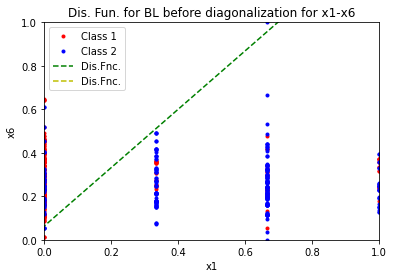

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


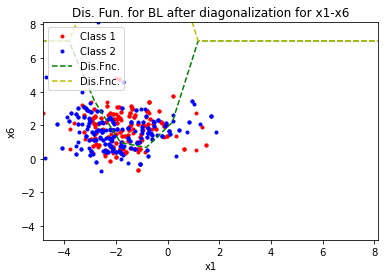

In [13]:
#@title Plotting Bayes dicriminant for BL
bayesDiscriminant(x1_bl_estimated_mean, x2_bl_estimated_mean, x1_ml_estimated_cov,
                                    x2_ml_estimated_cov, x1_matrix, x2_matrix, p1, p2, 1, 6, 'BL before diagonalization')
bayesDiscriminant(v1_bl_estimated_mean, v2_bl_estimated_mean, v1_ml_estimated_cov,
                                    v2_ml_estimated_cov, v1_matrix, v2_matrix, p1, p2, 1, 6, 'BL after diagonalization')

In [14]:
#@title Calculating Mean and Covariance using Parzen Window
x1_parzen_estimated_mean, x2_parzen_estimated_mean, x1_parzen_estimated_covariance, x2_parzen_estimated_covariance = parzenEstimations(x1_matrix, x2_matrix, False, 6)
print('\nEstimated mean 1 using Parzen before Diagonalization:')
print(x1_parzen_estimated_mean)
print('\nEstimated mean 2 using Parzen before Diagonalization:')
print(x2_parzen_estimated_mean)

print('\nEstimated covariance 1 using Parzen before Diagonalization:')
print(x1_parzen_estimated_covariance)
print('\nEstimated covariance 2 using Parzen before Diagonalization:')
print(x2_parzen_estimated_covariance)
v1_parzen_estimated_mean, v2_parzen_estimated_mean, v1_parzen_estimated_covariance, v2_parzen_estimated_covariance = parzenEstimations(v1_matrix, v2_matrix, False, 6)
print('\nEstimated mean 1 using Parzen after Diagonalization:')
print(v1_parzen_estimated_mean)
print('\nEstimated mean 2 using Parzen after Diagonalization:')
print(v2_parzen_estimated_mean)

print('\nEstimated covariance 1 using Parzen after Diagonalization:')
print(v1_parzen_estimated_covariance)
print('\nEstimated covariance 2 using Parzen after Diagonalization:')
print(v2_parzen_estimated_covariance)



Estimated mean 1 using Parzen before Diagonalization:
[[0.10303603]
 [0.39777805]
 [0.38246823]
 [0.19683628]
 [0.0550892 ]
 [0.18013083]]

Estimated mean 2 using Parzen before Diagonalization:
[[0.32873203]
 [0.47901654]
 [0.37744067]
 [0.26819603]
 [0.05294027]
 [0.24378492]]

Estimated covariance 1 using Parzen before Diagonalization:
[[0.12737329 0.         0.         0.         0.         0.        ]
 [0.         0.07749238 0.         0.         0.         0.        ]
 [0.         0.         0.09467771 0.         0.         0.        ]
 [0.         0.         0.         0.13360272 0.         0.        ]
 [0.         0.         0.         0.         0.11671797 0.        ]
 [0.         0.         0.         0.         0.         0.05999645]]

Estimated covariance 2 using Parzen before Diagonalization:
[[0.12204961 0.         0.         0.         0.         0.        ]
 [0.         0.06613288 0.         0.         0.         0.        ]
 [0.         0.         0.09142624 0.        

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


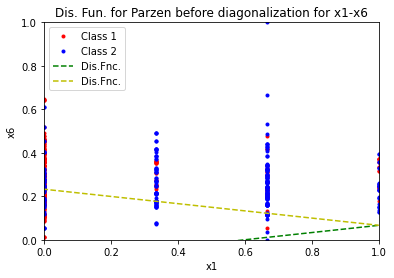

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


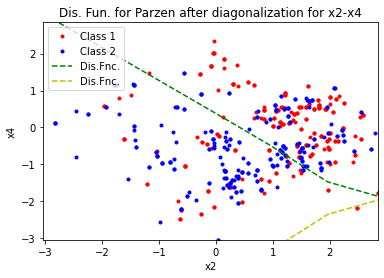

In [15]:
#@title Plotting Bayes dicriminant for Parzen Window
bayesDiscriminant(x1_parzen_estimated_mean, x2_parzen_estimated_mean, x1_parzen_estimated_covariance,
                                    x2_parzen_estimated_covariance, x1_matrix, x2_matrix, p1, p2, 1, 6, 'Parzen before diagonalization')
bayesDiscriminant(v1_parzen_estimated_mean, v2_parzen_estimated_mean, v1_parzen_estimated_covariance,
                                    v2_parzen_estimated_covariance, v1_matrix, v2_matrix, p1, p2, 2, 4, 'Parzen after diagonalization')

In [16]:
#@title Testing using 5-fold cross validation
def k_cross_validation(class1_data, class2_data, p1, p2, k, n1, n2, x1_estimated_mean, x1_estimated_cov, x2_estimated_mean, x2_estimated_cov, is_bayes):
    test_results_class1 = []
    test_results_class2 = []

    accuracies = []

    for i in range(0, k, 1):
        # print('Cross:' + str(i + 1))
        class1_testing_points_count = int(n1 / k)
        class1_training_points_count = int(n1 - n1 / k)
        class1_start = int(n1 * i / k)
        class1_end = int((i + 1) * n1 / k)

        class2_testing_points_count = int(n2 / k)
        class2_training_points_count = int(n2 - n2 / k)
        class2_start = int(n2 * i / k)
        class2_end = int((i + 1) * n2 / k)

        # print("start:", class1_start, "\tend:", class1_end)
        # print("start:", class2_start, "\tend:", class2_end)

        class1_test_points = class1_data[:, class1_start: class1_end]
        class1_train_points = class1_data[:, 0:class1_start]
        class1_train_points = np.append(class1_train_points, class1_data[:, class1_end:], axis=1)

        class2_test_points = class2_data[:, class2_start: class2_end]
        class2_train_points = class2_data[:, 0:class2_start]
        class2_train_points = np.append(class2_train_points, class2_data[:, class2_end:], axis=1)
        class1_accuracy, class2_accuracy, total_accuracy = 0, 0, 0
        if is_bayes:
          class1_accuracy, class2_accuracy, total_accuracy = test_classifier(class1_test_points, class2_test_points,
                                                                                  x1_estimated_cov,
                                                                                  x2_estimated_cov,
                                                                                  x1_estimated_mean,
                                                                                  x2_estimated_mean,
                                                                                  class1_testing_points_count,
                                                                                  class2_testing_points_count, p1, p2)
        
        
        test_results_class1 = np.append(test_results_class1, class1_accuracy)
        test_results_class2 = np.append(test_results_class2, class2_accuracy)

        accuracies = np.append(accuracies, total_accuracy)

    print('\nAverage Accuracy:', np.mean(accuracies))
    return test_results_class1, test_results_class2

#########################################################################################
# TESTING
#######################################################################################
test_results_ml_class1, test_results_ml_class2 = k_cross_validation(x1_matrix, x2_matrix, p1, p2, 5,
                                                                          len(x1_matrix[0]),
                                                                          len(x2_matrix[0]), 
                                                                          x1_ml_estimated_mean, x1_ml_estimated_cov,
                                                                          x2_ml_estimated_mean, x2_ml_estimated_cov, True)

print('\nML Accuracy Before Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)
#######################################################################################
test_results_ml_class1_d, test_results_ml_class2_d = k_cross_validation(v1_matrix, v2_matrix, p1, p2, 5,
                                                                          len(v1_matrix[0]),
                                                                          len(v2_matrix[0]), 
                                                                          v1_ml_estimated_mean, v1_ml_estimated_cov,
                                                                          v2_ml_estimated_mean, v2_ml_estimated_cov, True)

print('\nML Accuracy After Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1_d)])
x.add_row(["class 2", np.mean(test_results_ml_class2_d)])
print(x)
#######################################################################################
test_results_bl_class1, test_results_bl_class2 = k_cross_validation(x1_matrix, x2_matrix, p1, p2, 5,
                                                                          len(x1_matrix[0]),
                                                                          len(x2_matrix[0]), 
                                                                          x1_bl_estimated_mean, x1_ml_estimated_cov,
                                                                          x2_bl_estimated_mean, x2_ml_estimated_cov, True)

print('\nBL Accuracy Before Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_bl_class1)])
x.add_row(["class 2", np.mean(test_results_bl_class2)])
print(x)
###########################################################################################
test_results_ml_class1, test_results_ml_class2 = k_cross_validation(v1_matrix, v2_matrix, p1, p2, 5,
                                                                          len(v1_matrix[0]),
                                                                          len(v2_matrix[0]), 
                                                                          v1_bl_estimated_mean, v1_ml_estimated_cov,
                                                                          v2_bl_estimated_mean, v2_ml_estimated_cov, True)

print('\nBL Accuracy After Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)
###########################################################################################
test_results_ml_class1, test_results_ml_class2 = k_cross_validation(x1_matrix, x2_matrix, p1, p2, 5,
                                                                          len(x1_matrix[0]),
                                                                          len(x2_matrix[0]), 
                                                                          x1_parzen_estimated_mean, x1_parzen_estimated_covariance,
                                                                          x2_parzen_estimated_mean, x2_parzen_estimated_covariance, True)

print('\nParzen Accuracy Before Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)
##################################################################################
test_results_ml_class1, test_results_ml_class2 = k_cross_validation(v1_matrix, v2_matrix, p1, p2, 5,
                                                                          len(v1_matrix[0]),
                                                                          len(v2_matrix[0]), 
                                                                          v1_parzen_estimated_mean, v1_parzen_estimated_covariance,
                                                                          v2_parzen_estimated_mean, v2_parzen_estimated_covariance, True)

print('\nParzen Accuracy After Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)
###########################################################################################



Average Accuracy: 52.347362092005895

ML Accuracy Before Diagonalization:
+---------+--------------------+
|  Prd\Tr |      Accuracy      |
+---------+--------------------+
| class 1 | 1.2329931972789114 |
| class 2 | 98.88888888888889  |
+---------+--------------------+

Average Accuracy: 52.347362092005895

ML Accuracy After Diagonalization:
+---------+--------------------+
|  Prd\Tr |      Accuracy      |
+---------+--------------------+
| class 1 | 1.2329931972789114 |
| class 2 | 98.88888888888889  |
+---------+--------------------+

Average Accuracy: 52.347362092005895

BL Accuracy Before Diagonalization:
+---------+--------------------+
|  Prd\Tr |      Accuracy      |
+---------+--------------------+
| class 1 | 1.2329931972789114 |
| class 2 | 98.88888888888889  |
+---------+--------------------+

Average Accuracy: 52.347362092005895

BL Accuracy After Diagonalization:
+---------+--------------------+
|  Prd\Tr |      Accuracy      |
+---------+--------------------+
| class 1

In [24]:
#@title KNN Classification and Accuracy
########################################################################################
import math
import operator

# calculating Euclidean distance
def eucDistance(point, instance, length):
    distance = 0
    for x in range(length):
        distance += pow((point[x] - instance[x]), 2)
    return math.sqrt(distance)


def getNeighbors(test_point, class1, class2, k):
    neighbors = np.array([[], []])
    distances = np.array([[], []])
    class1 = np.array(class1).transpose()
    class2 = np.array(class2).transpose()
    for x in class1:
        dist = eucDistance(test_point, x, len(x))
        temp = np.array([[dist], [1]])
        distances = np.append(distances, temp, axis=1)
    for x in class2:
        dist = eucDistance(test_point, x, len(x))
        temp = np.array([[dist], [2]])
        distances = np.append(distances, temp, axis=1)

    class1_neighbor_count = 0
    class2_neighbor_count = 0

    distances = distances.transpose()
    distances = distances[distances[:, 0].argsort()]
    for x in range(0, k):
        if distances[x][1] == 1:
            class1_neighbor_count = class1_neighbor_count+1
        else:
            class2_neighbor_count = class2_neighbor_count+1

    point_class = 1 if class1_neighbor_count > class2_neighbor_count else 2
    return point_class

def knn_k_cross_validation(class1_data, class2_data, k, n1, n2, k_nn):
    test_results_knn_class1 = []
    test_results_knn_class2 = []

    accuracies = []

    for i in range(0, k, 1):
        # print('Cross:' + str(i + 1))
        class1_testing_points_count = int(n1 / k)
        class1_training_points_count = int(n1 - n1 / k)
        class1_start = int(n1 * i / k)
        class1_end = int((i + 1) * n1 / k)

        class2_testing_points_count = int(n2 / k)
        class2_training_points_count = int(n2 - n2 / k)
        class2_start = int(n2 * i / k)
        class2_end = int((i + 1) * n2 / k)

        class1_test_points = class1_data[:, class1_start: class1_end]
        class1_train_points = class1_data[:, 0:class1_start]
        class1_train_points = np.append(class1_train_points, class1_data[:, class1_end:], axis=1)

        class2_test_points = class2_data[:, class2_start: class2_end]
        class2_train_points = class2_data[:, 0:class2_start]
        class2_train_points = np.append(class2_train_points, class2_data[:, class2_end:], axis=1)

        class1_test_points = np.array(class1_test_points).transpose()
        class2_test_points = np.array(class2_test_points).transpose()

        class1_true = 0
        class1_false = 0

        class2_true = 0
        class2_false = 0

        for x in class1_test_points:
            classification = getNeighbors(x, class1_train_points, class2_train_points, k_nn)
            if classification == 1:
                class1_true = class1_true + 1
            else:
                class1_false = class1_false + 1

        for x in class2_test_points:
            classification = getNeighbors(x, class1_train_points, class2_train_points, k_nn)
            if classification == 2:
                class2_true = class2_true + 1
            else:
                class2_false = class2_false + 1

        class1_accuracy = (class1_true / len(class1_test_points)) * 100
        class2_accuracy = (class2_true / len(class2_test_points)) * 100

        test_results_knn_class1 = np.append(test_results_knn_class1, class1_accuracy)
        test_results_knn_class2 = np.append(test_results_knn_class2, class2_accuracy)

        accuracy = (class1_true + class2_true) * 100 / (len(class1_test_points) + len(class2_test_points))
        accuracies = np.append(accuracies, accuracy)
        # print(class1_testing_points_count, class2_testing_points_count)
        #
        # print(class1_true, class1_false)
        # print(class2_true, class2_false)
        # print(accuracy)
    print('\nK-NN Average Accuracy:', np.mean(accuracies))
    return test_results_knn_class1, test_results_knn_class2

test_results_ml_class1, test_results_ml_class2 = knn_k_cross_validation(x1_matrix_t, x2_matrix_t, 5,
                                                                          len(x1_matrix_t[0]),
                                                                          len(x2_matrix_t[0]), 
                                                                          3)
print('\nKNN Accuracy Before Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)
##################################################################################
test_results_ml_class1, test_results_ml_class2 = knn_k_cross_validation(v1_matrix_t, v2_matrix_t, 5,
                                                                          len(v1_matrix_t[0]),
                                                                          len(v2_matrix_t[0]), 
                                                                          1)

print('\nKNN Accuracy After Diagonalization:')
x = PrettyTable()
x.field_names = ["Prd\\Tr", "Accuracy"]
x.add_row(["class 1", np.mean(test_results_ml_class1)])
x.add_row(["class 2", np.mean(test_results_ml_class2)])
print(x)



K-NN Average Accuracy: 79.36036550542548

KNN Accuracy Before Diagonalization:
+---------+-------------------+
|  Prd\Tr |      Accuracy     |
+---------+-------------------+
| class 1 | 78.82352941176471 |
| class 2 | 79.88687782805431 |
+---------+-------------------+

K-NN Average Accuracy: 90.46640015229393

KNN Accuracy After Diagonalization:
+---------+-------------------+
|  Prd\Tr |      Accuracy     |
+---------+-------------------+
| class 1 | 92.15686274509804 |
| class 2 | 88.80090497737557 |
+---------+-------------------+
